In [1]:
import numpy as np

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.metrics import confusion_matrix
import itertools

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

In [5]:
from keras.utils import np_utils

Using Theano backend.


In [6]:
from data_utils import *
from tetrode import *

/home/linggel/anaconda2/envs/deeplearning/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
rat_name = 'mitt'

In [10]:
tetrode_data, decoding_target, tetrode_ids, tetrode_units, spike_data_binned, lfp_data_sampled = prepare_data(rat_name)

Current tetrode 12 with 16 neurons/units
(207, 1, 17, 25)
Current tetrode 13 with 15 neurons/units
(207, 1, 16, 25)
Current tetrode 14 with 4 neurons/units
(207, 1, 5, 25)
Current tetrode 15 with 2 neurons/units
(207, 1, 3, 25)
Current tetrode 16 with 6 neurons/units
(207, 1, 7, 25)
Current tetrode 17 with 2 neurons/units
(207, 1, 3, 25)
Current tetrode 18 with 12 neurons/units
(207, 1, 13, 25)
Current tetrode 19 with 15 neurons/units
(207, 1, 16, 25)
Current tetrode 20 with 12 neurons/units
(207, 1, 13, 25)
Current tetrode 22 with 1 neurons/units
(207, 1, 2, 25)
Current tetrode 23 with 4 neurons/units
(207, 1, 5, 25)
Current tetrode 3 with 4 neurons/units
(207, 1, 5, 25)
Current tetrode 7 with 3 neurons/units
(207, 1, 4, 25)
Current tetrode 8 with 1 neurons/units
(207, 1, 2, 25)
Current tetrode 9 with 7 neurons/units
(207, 1, 8, 25)


In [11]:
y_true, y_hat = cross_validate(tetrode_data, decoding_target, tetrode_ids, tetrode_units)

Current fold validation accuracy: 0.363636358218
Current fold validation accuracy: 0.454545454545
Current fold validation accuracy: 0.500000010837
Current fold validation accuracy: 0.772727283564
Current fold validation accuracy: 0.454545459964
Current fold validation accuracy: 0.590909101746
Current fold validation accuracy: 0.428571417218
Current fold validation accuracy: 0.666666686535
Current fold validation accuracy: 0.5
Current fold validation accuracy: 0.722222208977


In [12]:
print(np.mean(y_true.argmax(-1) == y_hat.argmax(-1)))

0.454106280193


In [13]:
matrix = confusion_matrix(y_true.argmax(-1), y_hat.argmax(-1))

Normalized confusion matrix
[[ 0.8030303   0.13636364  0.03030303  0.03030303]
 [ 0.35087719  0.42105263  0.15789474  0.07017544]
 [ 0.29787234  0.29787234  0.25531915  0.14893617]
 [ 0.18918919  0.51351351  0.16216216  0.13513514]]


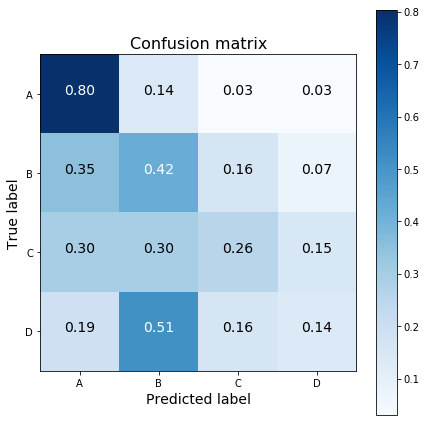

In [14]:
fig = plt.figure(figsize=(6, 6))
plot_confusion_matrix(matrix, classes=['A', 'B', 'C', 'D'], normalize=True,
                      title='Confusion matrix')
plt.show()

In [15]:
model = build_tetrode_model(tetrode_ids, tetrode_units)

In [16]:
hist = model.fit(tetrode_data, decoding_target, nb_epoch=100, batch_size=20, 
                 verbose=0, validation_split=0.1, shuffle=True)

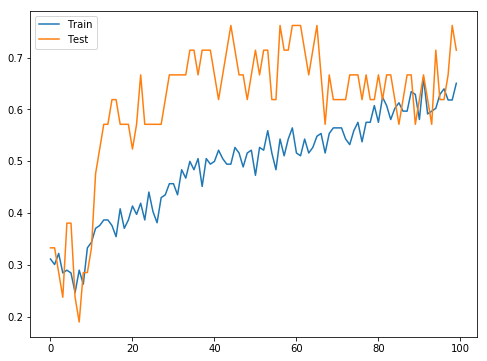

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.plot(hist.history['acc'], label='Train')
plt.plot(hist.history['val_acc'], label='Test')
plt.legend()
plt.show()

In [18]:
from helper import extract_latent

In [19]:
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(model.layers[-3].name).output)

In [20]:
all_lower = extract_latent(intermediate_layer_model, spike_data_binned, lfp_data_sampled,
                          tetrode_ids, tetrode_units, 25, 20)

In [21]:
print(all_lower.shape)

(207, 18, 10)


In [22]:
for i in range(10):
    model = build_tetrode_model(tetrode_ids, tetrode_units)
    hist = model.fit(tetrode_data, decoding_target, nb_epoch=100, batch_size=20, verbose=0, validation_split=0.1, shuffle=True)
    intermediate_layer_model = Model(input=model.input, output=model.get_layer(model.layers[-3].name).output)
    all_lower = extract_latent(intermediate_layer_model, spike_data_binned, lfp_data_sampled, tetrode_ids, tetrode_units, 25, 20)
    np.save('{name}_latent_{index}.npy'.format(name=rat_name, index=i), all_lower)